In [1]:
from datascience import *
import numpy as np

import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
%matplotlib inline

## The Toast Myth

We saw the Mythbusters crew do an experiment with 48 pieces of toast, where 29 landed butter side up and 19 butter side down.  Let's see if we can figure out how likely this outcome would be, if toast was equally likely to land on either side.  In particular, we'll play a "what-if" game: what if toast was equally likely to land on both sides?  Let's simulate what would happen, under that assumption.

In [2]:
possible_outcomes = Table.read_table('toast_possible.csv')

In [3]:
possible_outcomes

Outcome
Butter Side Up
Butter Side Down


In [4]:
simulated_experiment = possible_outcomes.sample(48)

In [5]:
simulated_experiment

Outcome
Butter Side Up
Butter Side Up
Butter Side Down
Butter Side Up
Butter Side Down
Butter Side Up
Butter Side Up
Butter Side Down
Butter Side Down
Butter Side Up


In [6]:
simulated_experiment.group('Outcome')

Outcome,count
Butter Side Down,26
Butter Side Up,22


In [7]:
number_up = simulated_experiment.group('Outcome').where('Outcome', 'Butter Side Up')['count'][0]

In [8]:
number_up

22

## Repeated simulation

Now we're going to repeat the simulation 10000 times, and keep track of the statistic (the count of butter-side-up) we get from each simulation.

In [9]:
counts = make_array()
for i in np.arange(10000): # 10000 repetitions
    one_simulation = possible_outcomes.sample(48)
    number_up = one_simulation.group('Outcome').where('Outcome', 'Butter Side Up')['count'][0]
    counts = np.append(counts, number_up)
results = Table().with_column('Number that landed butter-side-up', counts)

In [10]:
results

Number that landed butter-side-up
25
21
21
26
25
24
26
26
26
20


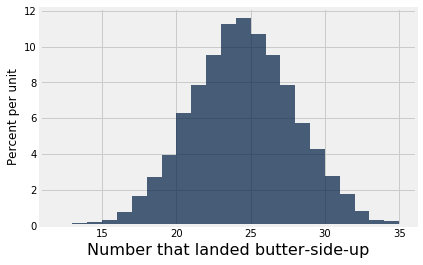

In [11]:
results.hist(bins=np.arange(12,36,1))

In [12]:
results.where('Number that landed butter-side-up', are.above_or_equal_to(29)).num_rows / 10000

0.1012

In [13]:
results.where('Number that landed butter-side-up', are.not_between(20, 29)).num_rows / 10000

0.1974

## Swain v Alabama

In [14]:
swain = Table().with_columns(
    'Ethnicity', make_array('Black', 'Other'),
    'Eligible', make_array(0.26, 0.74),
    'Panel', make_array(0.08, 0.92)
)

swain.set_format([1, 2], PercentFormatter(0))

Ethnicity,Eligible,Panel
Black,26%,8%
Other,74%,92%


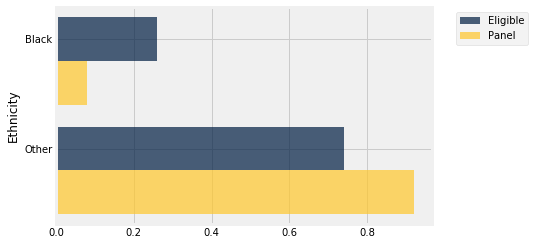

In [15]:
swain.barh(0)

## Total Variation Distance

In [16]:
diff = swain.with_column('Difference', swain.column(1) - swain.column(2))
diff

Ethnicity,Eligible,Panel,Difference
Black,26%,8%,0.18
Other,74%,92%,-0.18


In [17]:
abs_diff = diff.with_column('Abs. Difference', np.abs(diff.column(3)))
abs_diff

Ethnicity,Eligible,Panel,Difference,Abs. Difference
Black,26%,8%,0.18,0.18
Other,74%,92%,-0.18,0.18


In [18]:
sum(abs_diff.column(4)) / 2

0.18000000000000002

In [19]:
def total_variation_distance(distribution_1, distribution_2):
    """Each distribution is an array of proportions that sums to 1."""
    return np.abs(distribution_1 - distribution_2).sum()/2

In [20]:
def table_tvd(table, label_1, label_2):
    return total_variation_distance(table.column(label_1), table.column(label_2))

In [21]:
table_tvd(swain, 'Eligible', 'Panel')

0.18000000000000002

## Simulating the statistic, for Swain v. Alabama

In [22]:
swain.sample(10)

Ethnicity,Eligible,Panel
Other,74%,92%
Black,26%,8%
Other,74%,92%
Black,26%,8%
Black,26%,8%
Other,74%,92%
Black,26%,8%
Black,26%,8%
Black,26%,8%
Other,74%,92%


In [23]:
ethnicity = swain.select(0)
ethnicity

Ethnicity
Black
Other


In [24]:
ethnicity.sample(10)

Ethnicity
Other
Other
Other
Other
Black
Black
Other
Other
Other
Black


In [25]:
population_distribution = swain.column('Eligible')
population_distribution

array([ 0.26,  0.74])

In [26]:
ethnicity.sample(10, weights=population_distribution)

Ethnicity
Other
Other
Other
Other
Black
Other
Other
Other
Other
Other


In [27]:
panel_size = 100
swain.select(0).sample(panel_size, weights=swain.column('Eligible'))

Ethnicity
Black
Other
Other
Other
Other
Other
Black
Other
Other
Other


In [28]:
panel = swain.select(0).sample(panel_size, weights=swain.column('Eligible'))
counts = panel.group(0)
sample_proportions = counts.select(0).with_column('Random', counts.column(1) / panel_size)
sample_proportions.set_format(1, PercentFormatter(0))

Ethnicity,Random
Black,34%
Other,66%


In [29]:
swain

Ethnicity,Eligible,Panel
Black,26%,8%
Other,74%,92%


In [30]:
swain.join('Ethnicity', sample_proportions)

Ethnicity,Eligible,Panel,Random
Black,26%,8%,34%
Other,74%,92%,66%


In [31]:
def random_jury_panel():
    panel = swain.select(0).sample(panel_size, weights=swain.column('Eligible'))
    counts = panel.group(0)
    sample_proportions = counts.select(0).with_column('Random', counts.column(1) / panel_size)
    sample_proportions.set_format(1, PercentFormatter(0))
    return swain.join('Ethnicity', sample_proportions)

In [32]:
random_jury_panel()

Ethnicity,Eligible,Panel,Random
Black,26%,8%,29%
Other,74%,92%,71%


## Repeating the simulation multiple times, for Swain v. Alabama

In [33]:
# Compute the empirical distribution of TVDs

tvds = make_array()

for i in np.arange(10000): # Repetitions
    new_sample = random_jury_panel()
    tvds = np.append(tvds, table_tvd(new_sample, 'Eligible', 'Random'))

results = Table().with_column('TVD between the population & a random sample', tvds)
results

TVD between the population & a random sample
0.07
0.01
0.04
0.03
0.06
0.02
0.04
0.01
0
0.03


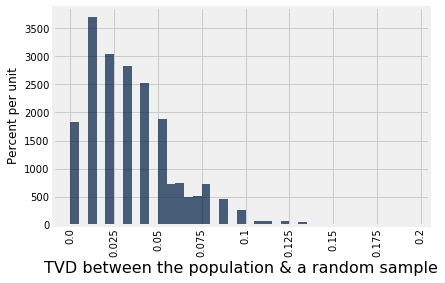

In [34]:
results.hist(bins=np.arange(0, 0.20, 0.005))

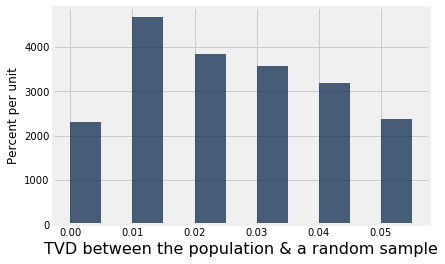

In [35]:
results.hist(bins=np.arange(0, 0.06, 0.005))

## Alameda County Juries

In [36]:
# Data from an ACLU 2010 report
# Racial and Ethnic Disparities in Alameda County Jury Pools
# https://www.aclunc.org/sites/default/files/racial_and_ethnic_disparities_in_alameda_county_jury_pools.pdf

panels = Table().with_columns(
    'Ethnicity', make_array('Asian', 'Black', 'Latino', 'White', 'Other'),
    'Eligible', make_array(0.15, 0.18, 0.12, 0.54, 0.01),
    'Panels', make_array(0.26, 0.08, 0.08, 0.54, 0.04)
)

panels.set_format([1, 2], PercentFormatter(0))

Ethnicity,Eligible,Panels
Asian,15%,26%
Black,18%,8%
Latino,12%,8%
White,54%,54%
Other,1%,4%


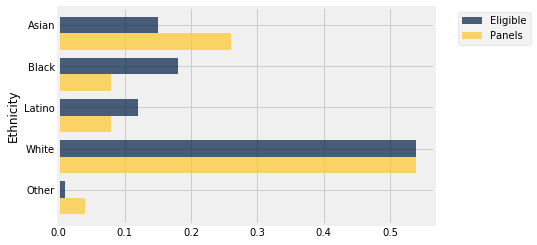

In [37]:
panels.barh(0)

In [38]:
def total_variation_distance(distribution_1, distribution_2):
    """Each distribution is an array of proportions that sums to 1."""
    return np.abs(distribution_1 - distribution_2).sum()/2

def table_tvd(table, label_1, label_2):
    return total_variation_distance(table.column(label_1), table.column(label_2))

table_tvd(panels, 'Eligible', 'Panels')

0.14000000000000001

In [39]:
Table().with_columns('side', ['heads', 'tails']).sample(1000, weights=[.8, .2]).group(0)

side,count
heads,808
tails,192


In [40]:
def sample_from_distribution(t, category_label, distribution_label, sample_size):
    categories = t.select(category_label)
    distribution = t.column(distribution_label)
    return categories.sample(sample_size, weights=distribution)

sample_from_distribution(panels, 'Ethnicity', 'Eligible', 10)

Ethnicity
White
White
White
White
Latino
Latino
White
White
Latino
White


In [41]:
def with_random_sample(t, category_label, distribution_label, sample_size):
    """Return t with a column that contains category proportions of a random sample."""
    sample = sample_from_distribution(t, category_label, distribution_label, sample_size)
    counts = sample.group(0)
    sample_proportions = counts.select(0).with_column('Random', counts.column(1) / sample_size)
    sample_proportions.set_format(1, PercentFormatter(0))
    return t.join(category_label, sample_proportions)

with_random_sample(panels, 'Ethnicity', 'Eligible', 1453)

Ethnicity,Eligible,Panels,Random
Asian,15%,26%,15%
Black,18%,8%,18%
Latino,12%,8%,12%
Other,1%,4%,1%
White,54%,54%,54%


## Repeated simulations, for Alameda County

In [42]:
# Compute the empirical distribution of TVDs

tvds = make_array()

for i in np.arange(1000): # Repetitions
    new_sample = with_random_sample(panels, 'Ethnicity', 'Eligible', 1453)
    tvds = np.append(tvds, table_tvd(new_sample, 'Eligible', 'Random'))

results = Table().with_column('TVD between the population & a random sample', tvds)
results

TVD between the population & a random sample
0.0119133
0.0312663
0.0106813
0.0161253
0.0192017
0.0251273
0.024563
0.00970406
0.00792154
0.0257261


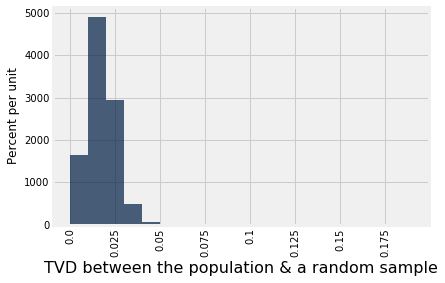

In [43]:
results.hist(bins=np.arange(0, 0.2, 0.01))